In [2]:
import numpy as np
import igl
import meshplot as mp
from scipy.spatial.transform import Rotation
import ipywidgets as iw
import time

In [3]:
# v, f = igl.read_triangle_mesh('data/hand.off')
# labels = np.load('data/hand.label.npy').astype(int)
v, f = igl.read_triangle_mesh('data/cactus.off')
labels = np.load('data/cactus.label.npy').astype(int)
v -= v.min(axis=0)
v /= v.max()

## Removal of high-frequency details

minimizing the thin-plate energy, which involves solving a bi-Laplacian system arising from the quadratic energy minimization:

$$
\begin{aligned}
\min_v v^TL_\omega M^{-1} L_\omega v \\
s.t. v_H = o_H
\end{aligned}
$$

$o_H$ are the handles of the vertex positions (boundary conditions). $v_H$ is the position of the handle vertices.

$L_\omega$ is the cotan Laplacian, the symmetric matrix consisting of the cotangent weights ONLY (without the division by Voronoi areas).
cotan weights: $w_{ij} = \frac{\cot \alpha_{ij} + \cot \beta_{ij}}2$
$$
L_{ij} = \begin{cases} 
w_{ij} \text{ if } i \neq j \\
\sum_{k\neq i} L_{ik} \text{ if } i = j 
\end{cases}
$$

$M$ is the mass matrix, inverse of $M$ applies the appropriate rescaling, it is a discretization of the inner-product


Setting the gradient wrt. $v$ to 0 and solve:

$$
\begin{aligned}
2 L_\omega M^{-1} L_\omega v = 0
\end{aligned}
$$

## Deforming the smooth mesh

$$
\begin{aligned}
\min_v v^TL_\omega M^{-1} L_\omega v \\
s.t. v_H = t(o_H)
\end{aligned}
$$

The computation of $t(o_H)$ is implemented in the `pos_f` code


In [4]:
import scipy.sparse as sp
from sksparse.cholmod import cholesky

# #v = 14347
# #f = 28690
# M.shape #v x #v
# L.shape #v x #v
# M.count_nonzero() == #v, diagonal
# labels.shape #v, 0 not labeled, >0 labeled

# Hard Constraints
def min_thinplate_energy(V, F, labels):
    Nv = V.shape[0]
    # Important: should not edit the linear system when the mesh deforms!!
    # Deforming the mesh cause poor triangles around the constraint, 
    # 
    M = igl.massmatrix(v,F) # mass matrix in sp.csc_matrix format
    L = igl.cotmatrix(v,F) # cotangent Laplacian 
    Minv = sp.diags(1 / M.data)
    A = 2 * L @ Minv @ L
    
    # modify L to remove the constraints from the system
    free_indices = np.where(labels == 0)[0]
    fixed_indices = np.where(labels != 0)[0]
    Nfree = free_indices.shape[0]
    
    # Extract Aff submatrix corresponding to free vertices
    Aff = A[free_indices, :][:, free_indices]
    Afc = A[free_indices, :][:, fixed_indices]
    # solve Aff vf = 0 - Afc vc
    rhs = np.zeros((Nfree,3)) - Afc * V[fixed_indices, :]
    chol_factor = cholesky(Aff)
    Vf = np.zeros((Nfree, 3))
    for i in range(3):
        # Vf[:, i] = sp.linalg.spsolve(Lff, rhs[:, i])
        Vf[:, i] = chol_factor(rhs[:, i])

    # Reassemble the full solution array
    V_full = np.zeros_like(V)
    V_full[free_indices, :] = Vf
    V_full[fixed_indices, :] = V[fixed_indices, :]
    
    return V_full

## Step 3: Transferring high-frequency details to the deformed surface

projection of the edge vector $E$ onto the tangent plane orthogonal to the normal $N$ at $v$ is given by:

$$
P = E−(E\cdot N)N
$$

Since the basis matrices are orthogonal, decomposing the displacement vector 
$d_i$ with respect to each basis can be efficiently done by computing the dot product of 
$d_i$ with each of the basis vectors 
$X$, 
$Y$, and 
$Z$

In [5]:
'''
From a original surface S and a minimized surface, extract the details
params:
    v (#v x 3): vertices coords corresponding to the original surface S
    vf (#v x 3): vertices coords corresponding to the minimized surface B
    f (#f x 3): faces of the surface

returns:
    max_vec_end (#v x 1): index of selected outgoing edge for each vertex
    di_xyz: representation of displacement vector at each vertex in 
'''
# original surface S corresponds to v
# the transformed mesh B corresponds to vf
def extract_detail(V, Vf, F):
    # per-vertex displacement
    d = V - Vf
    
    Nv = V.shape[0]
    ADJ = igl.adjacency_matrix(F);
    ADJ = sp.coo_matrix(ADJ)
    # nB, pB, cB is an orthonormal frame of B
    # compute the unit per-vertex normal of B
    nB = igl.per_vertex_normals(Vf, F)
    
    # Normalized projection of one of v's outgoing edges onto the tangent plane defined by the vertex normal.
    pB = np.zeros_like(nB)
    max_norms = np.zeros((Nv, 1))
    max_vec_end = -np.ones((Nv, 1), dtype='int64')
    # pick the largest outgoing edge for each vertex
    for i, j in zip(ADJ.row, ADJ.col):
        e = Vf[i] - Vf[j]
        ni = nB[i, :]
        # unit projection
        p = e - np.dot(e, ni) * ni
        if (np.linalg.norm(p) > max_norms[i]):
            pB[i, :] = p/np.linalg.norm(p)
            max_norms[i] = np.linalg.norm(p)
            max_vec_end[i] = j;

    # assert(np.min(max_vec_end) >= 0)
    # cross product of the two above
    cB = np.cross(nB, pB, axis=1)
    print(np.linalg.norm(cB, axis=1).shape)

    # decompose the displacement in the frame's basis
    dx = np.einsum('ij,ij->i', d, pB) # d * pB
    dy = np.einsum('ij,ij->i', d, cB) # d * cB
    dz = np.einsum('ij,ij->i', d, nB) # d * nB
    # di_xyz = np.vstack((di_x, di_y, di_z)).T
    return max_vec_end, dx, dy, dz

'''
Add the details to the minimized surface to form a transformed local frame B'
params:
    V (#v x 3): vertices coords corresponding to the minimized transformed surface B'
    F (#f x 3): faces of the surface
    max_vec_end: choice of neighboring vectors (should be the SAME as in untransformed B)
    di_xyz: 
returns:
    V_new: adding detailed to B' to get the minimized transformed surface S'
'''
def apply_detail(V, F, max_vec_end, dx, dy, dz): 
    # nBp, pBp, cBp is an orthonormal frame of B'
    nBp = igl.per_vertex_normals(V, F)
    # pick the outgoing edge SAME as before
    pBp = np.zeros_like(nBp)
    for i in range(V.shape[0]):
        V2 = max_vec_end[i]
        e = V[i] - V[V2]
        p = e - np.dot(e, nBp[i]) * nBp[i]
        pBp[i] = p / np.linalg.norm(p)
    # cross product of the two above
    cBp = np.cross(nBp, pBp, axis=1)
    
    # represent the displacement in the frame's basis
    # dx = np.einsum('ij,i->ij', pBp, di_xyz[:,0])
    # dy = np.einsum('ij,i->ij', cBp, di_xyz[:,1])
    # dz = np.einsum('ij,i->ij', nBp, di_xyz[:,2])
    # return V + dx + dy + dz
    displacement_p = dx[:, np.newaxis] * pBp + dy[:, np.newaxis] * cBp + dz[:, np.newaxis] * nBp
    
    return V + displacement_p

In [5]:
# v, f = igl.read_triangle_mesh('data/woody-hi.off')
# labels = np.load('data/woody-hi.label.npy').astype(int)

In [6]:
handle_vertex_positions = v.copy()
pos_f_saver = np.zeros((labels.max() + 1, 6))
def pos_f(s,x,y,z, α, β, γ):
    slices = (labels==s)
    r = Rotation.from_euler('xyz', [α, β, γ], degrees=True)
    displacement = np.array([[x,y,z]])
    v_slice = v[slices] + displacement;
    center = v_slice.mean(axis=0)
    handle_vertex_positions[slices] = r.apply(v_slice - center) + center
    pos_f_saver[s - 1] = [x,y,z,α,β,γ]
    t0 = time.time()
    v_deformed = pos_f.deformer(handle_vertex_positions)
    p.update_object(vertices = v_deformed)
    t1 = time.time()
    print('FPS', 1/(t1 - t0))
pos_f.deformer = lambda x:x

In [7]:
# extract detail from the original mesh
B = min_thinplate_energy(v, f, labels)
max_vec_end, dx, dy, dz = extract_detail(v, B, f)

def position_deformer(target_pos):
    # Compute the transformed minimized mesh B'
    Bp = min_thinplate_energy(target_pos, f, labels)
    # apply the detail to the transformed mesh to get S'
    Sp = apply_detail(Bp, f, max_vec_end, dx, dy, dz)
    return Sp
    
''' Register this function to perform interactive deformation '''
pos_f.deformer = position_deformer

(5261,)


In [9]:
def widgets_wrapper():
    segment_widget = iw.Dropdown(options=np.arange(labels.max()) + 1)
    translate_widget = {i:iw.FloatSlider(min=-1, max=1, value=0.5, step=0.05) 
                        for i in 'xyz'}
    rotate_widget = {a:iw.FloatSlider(min=-90, max=90, value=0, step=1) 
                     for a in 'αβγ'}

    def update_seg(*args):
        (translate_widget['x'].value,translate_widget['y'].value,
        translate_widget['z'].value,
        rotate_widget['α'].value,rotate_widget['β'].value,
        rotate_widget['γ'].value) = pos_f_saver[segment_widget.value]
    segment_widget.observe(update_seg, 'value')
    widgets_dict = dict(s=segment_widget)
    widgets_dict.update(translate_widget)
    widgets_dict.update(rotate_widget)
    return widgets_dict

In [12]:
## Widget UI
from IPython.display import IFrame
color = (labels == 0).astype(int)

p = mp.plot(handle_vertex_positions, f, c=color)
iw.interact(pos_f,
            **widgets_wrapper())

p.save("static/q1.html")
IFrame(src='static/q1.html', width=700, height=600)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0517168…

interactive(children=(Dropdown(description='s', options=(1, 2, 3, 4), value=1), FloatSlider(value=0.5, descrip…

Plot saved to file static/q1.html.


## Outcome

The original mesh $S$, moving the constraint vertices result in bad triangles and mesh:

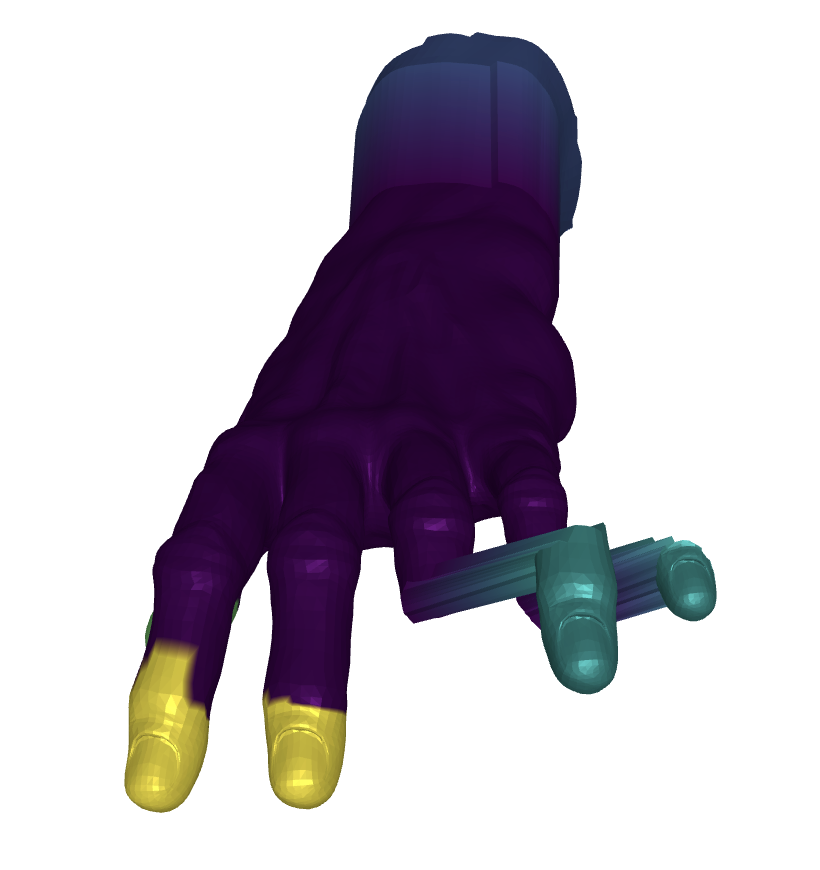

The minimized mesh $B$:

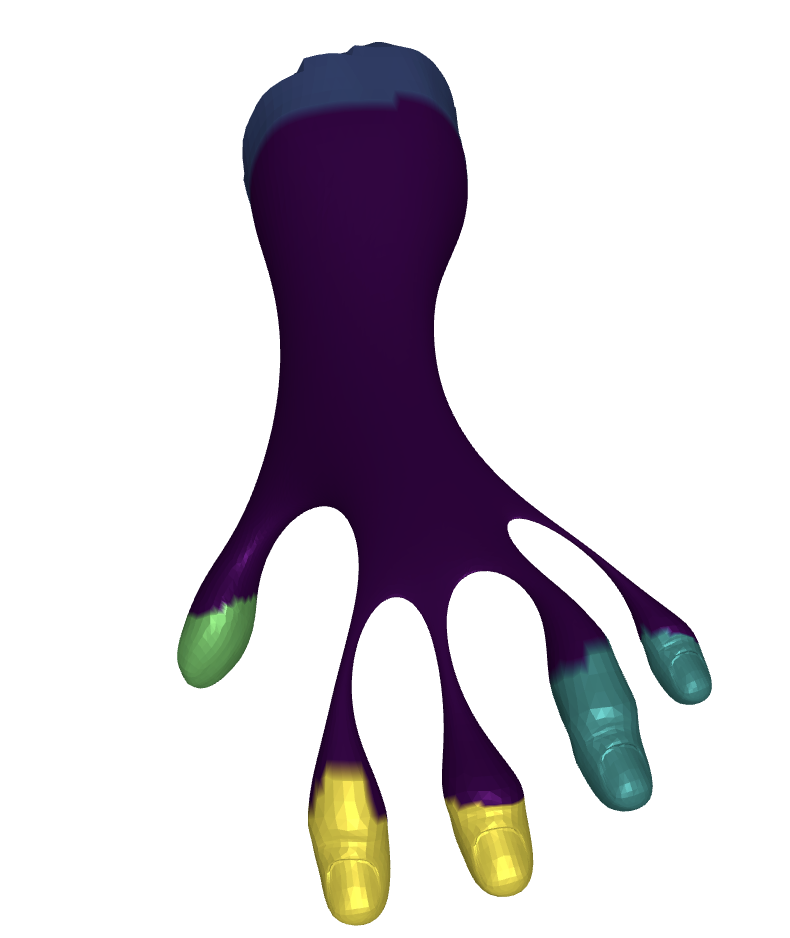

The transformed minimized mesh $B'$, moving the constraint vertices still gives you nice smooth mesh

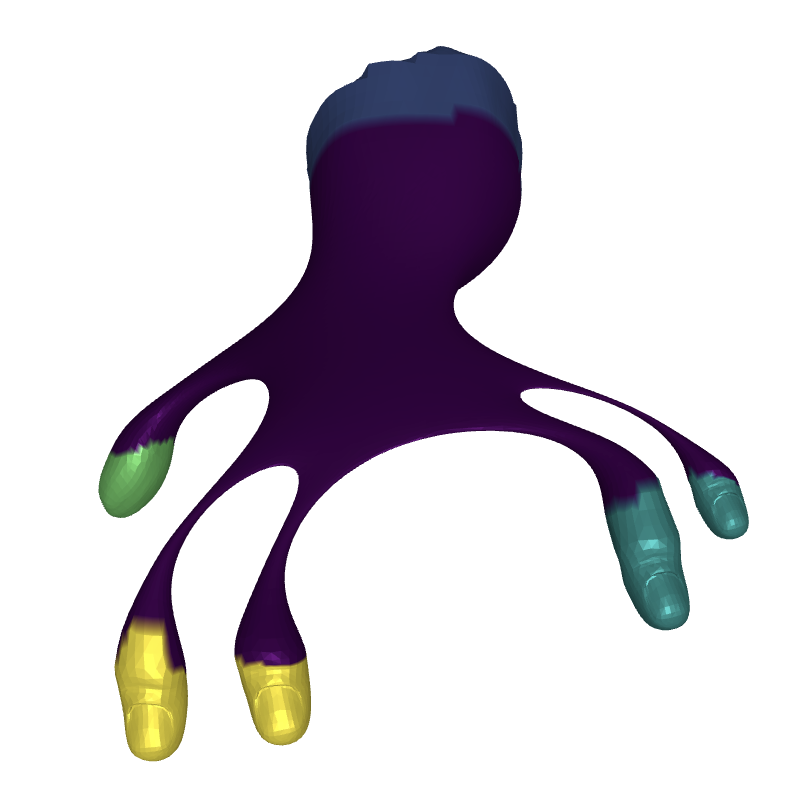

The transformed minimized mesh with details added $S'$:
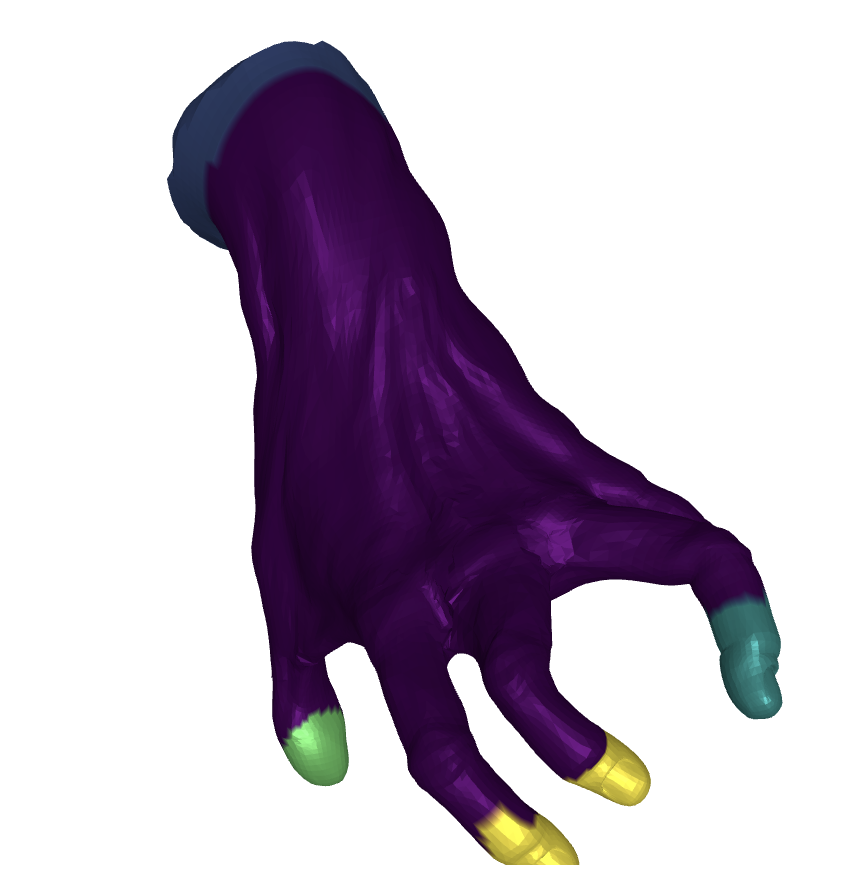


## Note:

**The widget does not work with Iframe so it does not display correctly on HTML, so please open in jupyter notebook**
 
The optimized widget works around 9 FPS for the hand mesh on my computer:

![title](img/screenshot.png)
